# Read the data

In [27]:
%load_ext autoreload
%autoreload 2

# --- library imports ---------------------------------------------------
from sbi_uhecr_radio_recon import read_data
import sbi_uhecr_radio_recon.utils as utils
from pathlib import Path
import torch
from torch.utils.data import DataLoader, random_split 
import numpy as np
from torch_geometric.data import Batch
#
# Number of simulations (or events) to process
#
num_events = 13_000

# path stored simulations and where you want to save the processed data
path_to_simulations = '/mnt/my-ssd/Zach_Data/Revised_Ground_Truth/' # Path to npy files
root_dir = '/mnt/my-ssd/Zach_Data/revised_saved_data' # Path to save data to


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# --- build dataset & loaders ------------------------------------------
dataset = read_data.CRsDataset(
    root        = root_dir,
    data_dir    = path_to_simulations,
    num_events  = 1_000,        # adjust as desired
    noise_std_ns= 5.0,          # GPS-like jitter
)

Loading processed data from /mnt/my-ssd/Zach_Data/revised_saved_data/processed/data.pt


In [3]:
# ============================================================
#  Deterministic data split and DataLoaders
#    • 70 % train
#    • 15 % validation  →  20 % Temperature calibration  +  80 % hold-out
#    • 15 % test
# ============================================================

# ------------------------------------------------------------------
# 1.  Primary split: train / val / test
# ------------------------------------------------------------------
total_n     = len(dataset)
train_size  = int(0.70 * total_n)
val_size    = int(0.15 * total_n)
test_size   = total_n - train_size - val_size          # remainder

split_seed  = read_data.SEED                                      
g_split     = torch.Generator().manual_seed(split_seed)

train_ds, val_ds, test_ds = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=g_split
)

# ------------------------------------------------------------------
# 2.  Secondary split: calibration vs. hold-out inside validation
#     (20 % of val → calibration, 80 % → hold-out)
# ------------------------------------------------------------------
CAL_FRAC    = 0.20
cal_size    = int(CAL_FRAC * len(val_ds))
hold_size   = len(val_ds) - cal_size

g_cal       = torch.Generator().manual_seed(split_seed + 1)

val_cal_ds, val_hold_ds = random_split(
    val_ds,
    [cal_size, hold_size],
    generator=g_cal
)

# ------------------------------------------------------------------
# 3.  DataLoaders
# -------------------------------------------------------------------
train_loader    = read_data.make_loader(train_ds,      16, True,  read_data.Collater)
val_cal_loader  = read_data.make_loader(val_cal_ds,    16, False, read_data.Collater)   # temperature T*
val_hold_loader = read_data.make_loader(val_hold_ds,   16, False, read_data.Collater)   # metrics / early-stop
test_loader     = read_data.make_loader(test_ds,       16, False, read_data.Collater)   # final evaluation



In [4]:
# Quick check
for batch, k_values in train_loader:
    print("batch:", batch)             # Graph data batch
    print("k_values:", k_values)       # Shape [16, 3] 
    print("pwf_dir:", batch.pwf_dir)   # Also shape [16, 3]
    # Perform training step...
    break

# Double check the ground truth and PWF directions have same shape and are stored correctly
for batch, theta_values in train_loader:
    print("batch.y.shape =", batch.y.shape)  # Should be [B, 2]
    print("batch.pwf_dir.shape =", batch.pwf_dir.shape)  # Should be [B, 2]
    
    # Check a couple of random indices for alignment
    i = 0
    print("Event 0 ground truth:", batch.y[i].cpu().numpy())
    print("Event 0 PWF dir:     ", batch.pwf_dir[i].cpu().numpy())
    break


batch: DataBatch(x=[1199, 4], edge_index=[2, 9377], edge_attr=[9377, 2], y=[16, 3], pwf_dir=[16, 3], coords=[1199, 3], trigger_times=[1199], batch=[1199], ptr=[17])
k_values: tensor([[-0.8063, -0.5891, -0.0534],
        [ 0.6487,  0.7577, -0.0715],
        [-0.7398,  0.2334, -0.6311],
        [-0.8480, -0.5184, -0.1103],
        [-0.0934, -0.9934, -0.0670],
        [ 0.2138,  0.9666, -0.1416],
        [ 0.3728, -0.8946, -0.2465],
        [ 0.0401,  0.9952, -0.0889],
        [ 0.6122,  0.5875, -0.5292],
        [ 0.6097,  0.2626, -0.7479],
        [-0.6263,  0.7778, -0.0523],
        [ 0.9800,  0.1691, -0.1049],
        [ 0.5553, -0.8280, -0.0779],
        [ 0.2477, -0.9655, -0.0800],
        [ 0.7940,  0.5336, -0.2912],
        [ 0.2727,  0.9510, -0.1459]])
pwf_dir: tensor([[-0.8051, -0.5905, -0.0560],
        [ 0.6482,  0.7579, -0.0742],
        [-0.7397,  0.2303, -0.6323],
        [-0.8474, -0.5185, -0.1139],
        [-0.0931, -0.9931, -0.0708],
        [ 0.2136,  0.9664, -0.1432],
 

# Pretrain the embedding network

In [ ]:
"""
Direction-correction encoder pre-training
- chordal loss 
- AMP, grad-scrub, cosine LR
"""

# ───────────── imports ──────────────────────────────────────────────────
from sbi_uhecr_radio_recon.utils import safe_tensor, xavier_, build_mlp
import math, torch, torch.nn as nn, torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool, global_max_pool

# ───────────── switches ────────────────────────────────────────
use_amp    = True          # set False -> pure FP32
num_epochs = 10


class DeltaKGNN(nn.Module):
    def __init__(self, in_ch=4, hidden=(128, 64), dropout=0.1,
                 agg="mean", mlp_hidden=(64, 64)):
        super().__init__()
        self.agg, self.dropout = agg.lower(), dropout
        self.convs = nn.ModuleList(
            [GCNConv(in_ch, hidden[0])] +
            [GCNConv(h1, h2) for h1, h2 in zip(hidden[:-1], hidden[1:])]
        )
        self.mlp = build_mlp(hidden[-1], mlp_hidden, dropout, nn.ReLU, 3)
        self.apply(xavier_)

    def forward(self, data):
        x = data.x
        for i, conv in enumerate(self.convs):
            x = F.relu(conv(x, data.edge_index))
            x = safe_tensor(x)
            if i < len(self.convs) - 1:
                x = F.dropout(x, p=self.dropout, training=self.training)

        if hasattr(data, "batch"):
            pool = dict(mean=global_mean_pool,
                        sum=global_add_pool,
                        max=global_max_pool)[self.agg]
            x = pool(x, data.batch)
        else:
            if   self.agg == "mean": x = x.mean(dim=0, keepdim=True)
            elif self.agg == "sum":  x = x.sum (dim=0, keepdim=True)
            elif self.agg == "max":  x = x.max(dim=0, keepdim=True)[0]

        delta_k = self.mlp(x)
        return x, delta_k

class FlexibleHybridKCorrector(nn.Module):
    def __init__(self, gnn_in=4, hidden=(128, 64), agg="mean",
                 mlp_hidden=(64, 64), gnn_dropout=0.1, normalize=True):
        super().__init__()
        self.normalize = normalize
        self.delta_gnn = DeltaKGNN(
            gnn_in, hidden, gnn_dropout, agg, mlp_hidden
        )
        self.gate = nn.Sequential(
            nn.Linear(hidden[-1] + 3, 64), nn.SiLU(),
            nn.Linear(64, 32), nn.SiLU(),
            nn.Linear(32, 1), nn.Sigmoid()
        )
        self.apply(xavier_)

    def forward(self, batch):
        emb, delta_k = self.delta_gnn(batch)
        alpha = self.gate(torch.cat([emb, batch.pwf_dir], dim=-1)).expand(-1, 3)
        k_final = batch.pwf_dir + alpha * delta_k
        return F.normalize(k_final, dim=-1) if self.normalize else k_final

# ═════════════════════ loss (chordal) ═══════════════════════════════════
class ChordalDirLoss(nn.Module):
    def __init__(self, eps: float = 1e-7): super().__init__(); self.eps = eps
    def forward(self, k_pred, k_true):
        k_pred = F.normalize(safe_tensor(k_pred), dim=-1, eps=self.eps)
        k_true = F.normalize(k_true, dim=-1, eps=self.eps)
        cos = (k_pred * k_true).sum(-1).clamp(-1., 1.)
        return (1.0 - cos).mean()

# ═════════════════════ training loop ═══════════════════════════════════
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amp_dtype = torch.bfloat16 if (use_amp and torch.cuda.is_bf16_supported()) else torch.float16

encoder   = FlexibleHybridKCorrector().to(device)
criterion = ChordalDirLoss()
optim     = torch.optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=2e-3)
sched     = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs)
scaler    = GradScaler(enabled=use_amp, init_scale=2**8)

best_med = float("inf")

for epoch in range(1, num_epochs + 1):
    # -------- training -------------------------------------------------
    encoder.train()
    for graph, k_true in train_loader:
        graph, k_true = graph.to(device), k_true.to(device)
        with autocast(dtype=amp_dtype, enabled=use_amp):
            k_pred = encoder(graph)
            loss   = criterion(k_pred, k_true)

        scaler.scale(loss).backward()
        scaler.unscale_(optim)
        for p in encoder.parameters():
            if p.grad is not None:
                p.grad.data = safe_tensor(p.grad.data)
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5.)
        scaler.step(optim); scaler.update(); optim.zero_grad(set_to_none=True)
    sched.step()

    # -------- validation ----------------------------------------------
    encoder.eval()
    errs = []
    with torch.no_grad(), autocast(dtype=amp_dtype, enabled=use_amp):
        for graph, k_true in val_hold_loader:
            graph, k_true = graph.to(device), k_true.to(device)
            k_pred = encoder(graph)
            ang = torch.acos((k_pred * k_true).sum(-1).clamp(-1, 1)) \
                    * 180. / math.pi
            errs.append(ang)

    errs = torch.cat(errs)              # [N_val]
    med  = errs.median().item()
    p95  = torch.quantile(errs, 0.95).item()

    print(f"Epoch {epoch:03d}  val_median = {med:.3f}° | val_95% = {p95:.3f}°")
    if med < best_med:
        best_med = med
        torch.save(encoder.state_dict(), "encoder_best.pt")
        print("        ↳ saved new best")

print(f"Training finished. Best validation median = {best_med:.3f}°")



Epoch 001  val_median = 0.261° | val_95% = 1.144°
        ↳ saved new best
Epoch 002  val_median = 0.261° | val_95% = 1.144°
Epoch 003  val_median = 0.261° | val_95% = 1.144°
Epoch 004  val_median = 0.261° | val_95% = 1.144°
Epoch 005  val_median = 0.261° | val_95% = 1.144°
Epoch 006  val_median = 0.261° | val_95% = 1.144°
Epoch 007  val_median = 0.261° | val_95% = 1.144°
Epoch 008  val_median = 0.261° | val_95% = 1.144°
Epoch 009  val_median = 0.261° | val_95% = 1.144°
Epoch 010  val_median = 0.261° | val_95% = 1.144°
Training finished. Best validation median = 0.261°


# Learn the posterior distribution (using LtU-ILI)

In [6]:
# LtU-ILI imports
import copy
import torch, matplotlib.pyplot as plt, matplotlib.colors as mcolors
from pathlib import Path
import ili
from ili.dataloaders import NumpyLoader, TorchLoader
from ili.utils          import load_nde_lampe, Uniform
from sbi_uhecr_radio_recon.runner_lampe_uhecr_radio import LampeFineTuneRunner

# load the training and validation data for the posterior inference
loader = TorchLoader(train_loader, val_hold_loader)


In [ ]:
##########################################
# Load the *pre-trained* encoder         #
##########################################

graphs_dir = Path("./"); graphs_dir.mkdir(parents=True, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding = FlexibleHybridKCorrector()
embedding.load_state_dict(torch.load("encoder_best.pt",
                                     map_location=device))
embedding.eval()            # freeze weights
embedding = embedding.cpu() # keep the master copy on CPU


In [ ]:
############################################################################################
# Build *various independent* Masked Autoegressive Flows (MAFs) if needed. One by default. #
############################################################################################
def make_maf():
    return load_nde_lampe(
        model='maf',
        hidden_features=80,
        num_transforms=8,
        embedding_net=copy.deepcopy(embedding),  # private copy
        x_normalize=False,
        device=device
    )

nets = [make_maf() for _ in range(1)]            # one MAF by default


In [10]:

#######################################################################
# Define prior distribution for the UHECR direction K direction vector#
#######################################################################
prior = Uniform(low=[-1, -1, -1], high=[1, 1, 1], device=device)

runner = LampeFineTuneRunner(
    prior      = prior,
    nets       = nets,          # three flows
    device     = device,
    train_args = {
        'training_batch_size': 64,
        'learning_rate': 2e-4   # phase-1 LR
    },
    out_dir    = None,
    name       = "maf_gnn_OM"
)

# per-run hyper-parameters
runner.lam_H         = 1e-3
runner.phase1_epochs = 40
runner.phase2_epochs = 25
runner.phase2_lr     = 1e-4

##########################################
# 4.  Train (two phases happen inside)   #
##########################################
posterior_ensemble, summaries = runner(loader=loader)

##########################################
# 5.  Plot validation log-p curves       #
##########################################
fig, ax = plt.subplots(figsize=(8,6))
cols = list(mcolors.TABLEAU_COLORS.values())
for i, m in enumerate(summaries):
    ax.plot(m['val_logp'], '-', c=cols[i % len(cols)],
            label=f"flow {i}")
ax.set_xlabel('Epoch'); ax.set_ylabel('Validation log-p'); ax.legend()
plt.savefig(graphs_dir / "train_validation_logp.png"); plt.close(fig)

print("Training complete - plots saved to", graphs_dir)


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:• flow 1/1
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 01/40  lp_val +6.413
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 02/40  lp_val +8.181
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 03/40  lp_val +8.703
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 04/40  lp_val +9.575
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 05/40  lp_val +10.673
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 06/40  lp_val +10.946
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 07/40  lp_val +11.139
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 08/40  lp_val +10.986
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 09/40  lp_val +10.907
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 10/40  lp_val +11.493
INFO:sbi_uhecr_radio_recon.runner_lampe_uhecr_radio:  phase1 11/40  lp_val

Training complete - plots saved to .


# Temperature calibration of the learned posterior

In [11]:
from sbi_uhecr_radio_recon.temperature_calibration import tune_temperature

posterior_tuned, T_opt = tune_temperature(
    posterior_ensemble, val_cal_loader, device="cuda")


INFO:root:Sampling models with [2048] samples each.



Scanning 11 temperatures for 68 % coverage target …



Drawing 8192 posterior samples: 9000it [00:00, 64475.51it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75345.27it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74514.62it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74737.10it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74358.01it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74379.99it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 72948.22it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 0.40  →  cov = 0.364,  median HPDI radius = 0.23°


Drawing 8192 posterior samples: 9000it [00:00, 75080.92it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76710.26it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 73616.28it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 69713.48it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 77499.44it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74841.86it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 72346.77it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 0.50  →  cov = 0.462,  median HPDI radius = 0.26°


Drawing 8192 posterior samples: 9000it [00:00, 75363.48it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75684.26it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 77091.57it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75561.85it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74764.33it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 72290.24it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75298.53it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 0.60  →  cov = 0.530,  median HPDI radius = 0.30°


Drawing 8192 posterior samples: 9000it [00:00, 72903.14it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76479.78it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 73471.14it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76560.59it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75489.77it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 72274.74it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 71393.89it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 0.70  →  cov = 0.603,  median HPDI radius = 0.33°


Drawing 8192 posterior samples: 9000it [00:00, 78170.92it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75631.49it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75781.35it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 70425.30it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76315.27it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75720.09it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75814.68it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 0.80  →  cov = 0.640,  median HPDI radius = 0.35°


Drawing 8192 posterior samples: 9000it [00:00, 73470.71it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75191.29it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75454.61it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76243.59it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 77159.49it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76662.43it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76659.32it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 0.90  →  cov = 0.696,  median HPDI radius = 0.38°


Drawing 8192 posterior samples: 9000it [00:00, 71209.92it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75677.28it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 70277.93it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 73358.77it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76349.22it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 77047.36it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76133.64it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 1.00  →  cov = 0.729,  median HPDI radius = 0.41°


Drawing 8192 posterior samples: 9000it [00:00, 76391.25it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76286.58it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 73410.13it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76124.74it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 67122.23it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74879.27it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 66169.43it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 1.50  →  cov = 0.826,  median HPDI radius = 0.54°


Drawing 8192 posterior samples: 9000it [00:00, 75706.12it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 77427.90it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76600.99it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74440.71it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74440.71it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76558.73it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74129.34it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 2.00  →  cov = 0.907,  median HPDI radius = 0.66°


Drawing 8192 posterior samples: 9000it [00:00, 71211.80it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 77356.66it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74375.59it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 70627.43it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 77011.36it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76449.27it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 68861.56it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 2.50  →  cov = 0.919,  median HPDI radius = 0.79°


Drawing 8192 posterior samples: 9000it [00:00, 77297.10it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76795.00it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 77028.33it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 70459.22it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 73305.21it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76320.36it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76291.67it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samp

T = 3.00  →  cov = 0.927,  median HPDI radius = 0.88°

Selected  T* = 0.90  (empirical cov = 0.696, median radius = 0.38°)



# Reconstruct test events (mock observations unseen by the learned model)

INFO:root:Sampling models with [1000] samples each.
Drawing 4000 posterior samples: 100%|██████████| 4000/4000 [00:00<00:00, 60519.06it/s]


51 antennas triggered
saved → ./hitpattern_event_.pdf


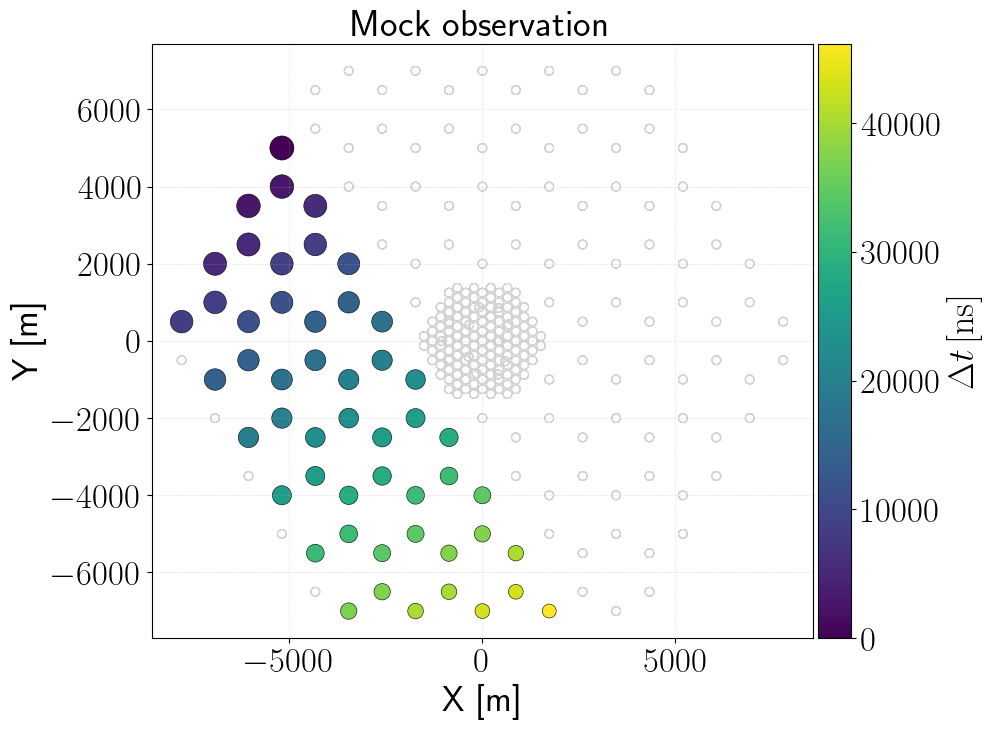

In [17]:
# ------------------------------------------------------------------
#  pick a random example from the *test* dataset
# ------------------------------------------------------------------
test_ind = np.random.randint(len(test_ds))
g        = test_ds[test_ind]           # PyG Data object
k_true   = g.y.view(-1, 3)[0].cpu().numpy()

# wrap it into a Batch so that .batch exists
g_batch  = Batch.from_data_list([g]).to(device)

# ------------------------------------------------------------------
#  sample from the trained ensemble
# ------------------------------------------------------------------
num_samples = 1000
torch.manual_seed(1234)

with torch.no_grad():
    samples  = posterior_tuned.sample((num_samples,), g_batch)
    #log_prob = posterior_tuned.log_prob(samples,          g_batch)

samples  = samples.cpu().numpy()          # [N,3]
#log_prob = log_prob.cpu().numpy()         # [N]

# ---------------------------------------------------------------------
# Let's take a peek at the event
# ---------------------------------------------------------------------
ref_coords = utils.build_master_geometry([train_ds, val_hold_ds, val_cal_ds, test_ds])

utils.plot_hit_pattern(
    g, ref_coords,
    graphs_dir='./',
    idx_event=None,
    figsize=(10, 8),   # user-adjustable
    fontsize=26        # now affects *every* text element
)


# Posterior reconstruction for this test event

INFO:root:Sampling models with [2000] samples each.
Drawing 8000 posterior samples: 100%|██████████| 8000/8000 [00:00<00:00, 61728.60it/s]


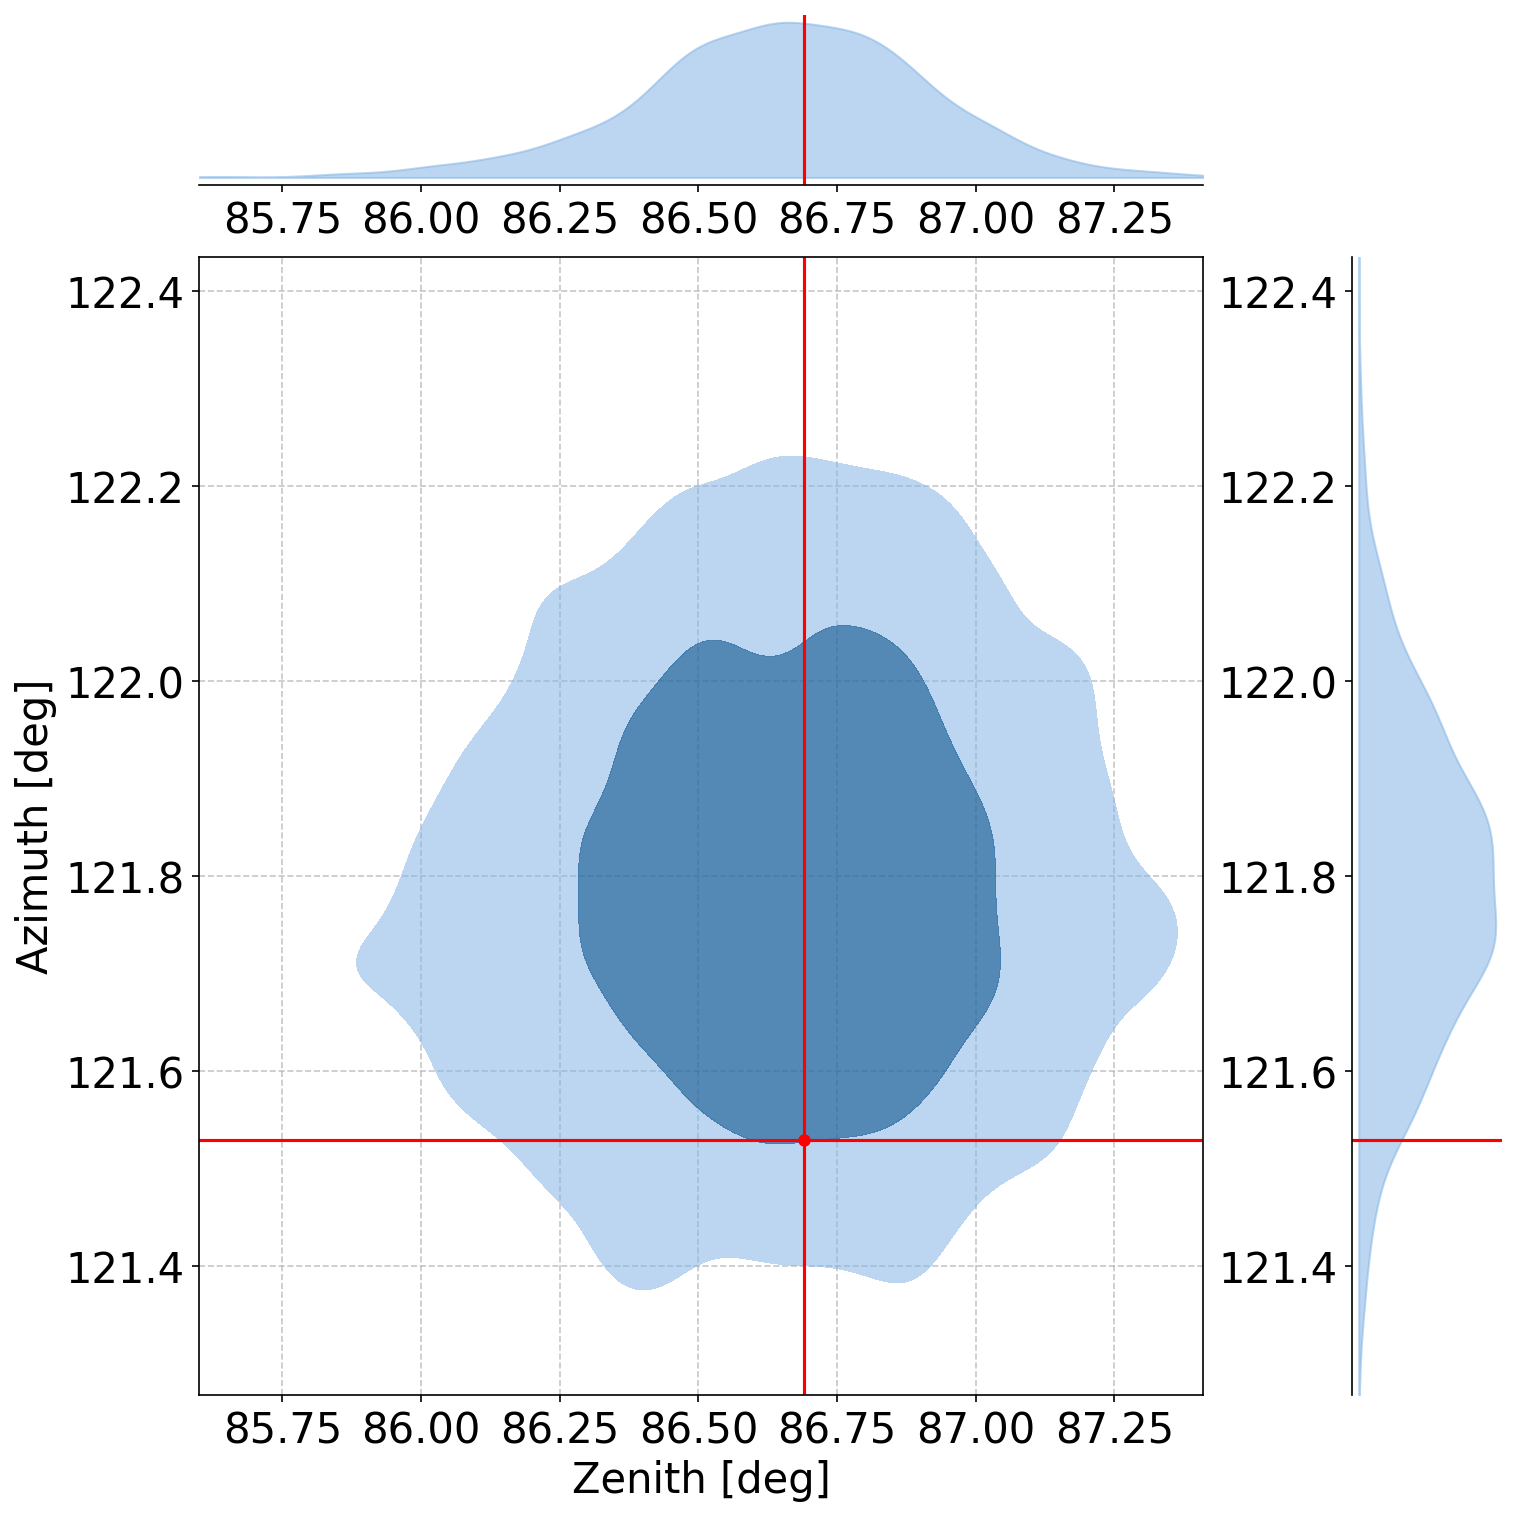

In [25]:
import sbi_uhecr_radio_recon.diagnostics as diagnostics

test_graphs = [test_ds[i] for i in range(len(test_ds))]
theta_true  = np.stack([g.y.view(-1,3)[0].cpu().numpy() for g in test_graphs])

plotter = diagnostics.PlotSinglePosteriorThetaPhi(
    num_samples   = 2000,
    out_dir       = None,   # or Path("./figs") if you want automatic names
    save_samples  = False
)

fig = plotter(
    posterior_tuned,
    x_obs     = g_batch,                      # a single PyG Data object
    signature = "event0_",              # prefix for any side-products
    out_pdf   = "./posterior_plot.pdf"  # PDF written here
)

plt.show()          # optional display


Drawing 4000 posterior samples: 100%|██████████| 4000/4000 [00:00<00:00, 73461.20it/s]
INFO:root:Sampling models with [1000] samples each.
Drawing 4000 posterior samples: 100%|██████████| 4000/4000 [00:00<00:00, 73858.66it/s]
INFO:root:Sampling models with [1000] samples each.
Drawing 4000 posterior samples: 100%|██████████| 4000/4000 [00:00<00:00, 75206.50it/s]
INFO:root:Sampling models with [1000] samples each.
Drawing 4000 posterior samples: 100%|██████████| 4000/4000 [00:00<00:00, 74042.83it/s]
INFO:root:Sampling models with [1000] samples each.
Drawing 4000 posterior samples: 100%|██████████| 4000/4000 [00:00<00:00, 71524.20it/s]
INFO:root:Sampling models with [1000] samples each.
Drawing 4000 posterior samples: 100%|██████████| 4000/4000 [00:00<00:00, 71164.98it/s]
INFO:root:Sampling models with [1000] samples each.
Drawing 4000 posterior samples: 100%|██████████| 4000/4000 [00:00<00:00, 75685.55it/s]
INFO:root:Sampling models with [1000] samples each.
Drawing 4000 posterior samp

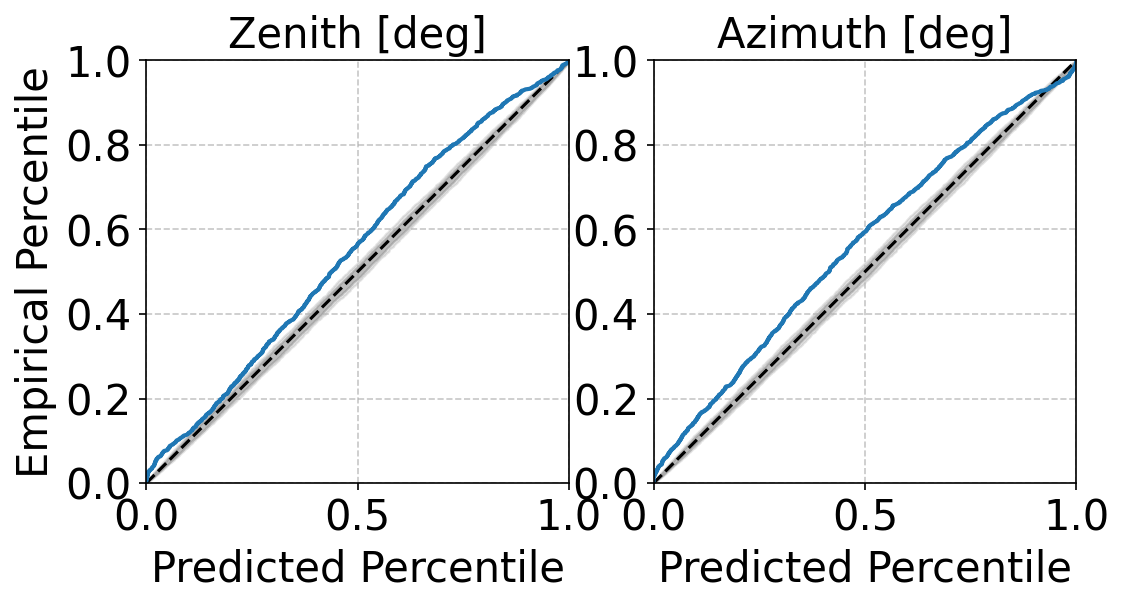

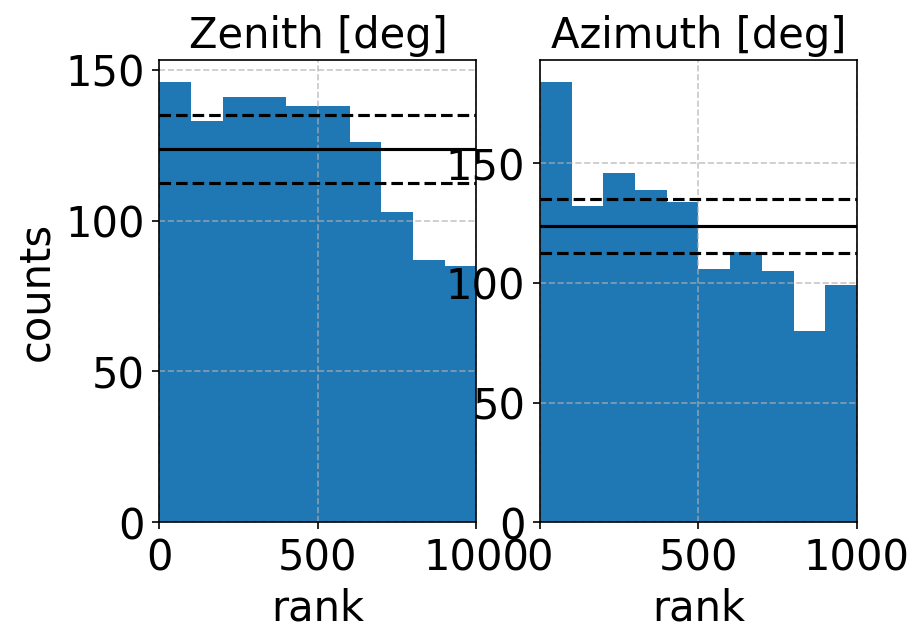

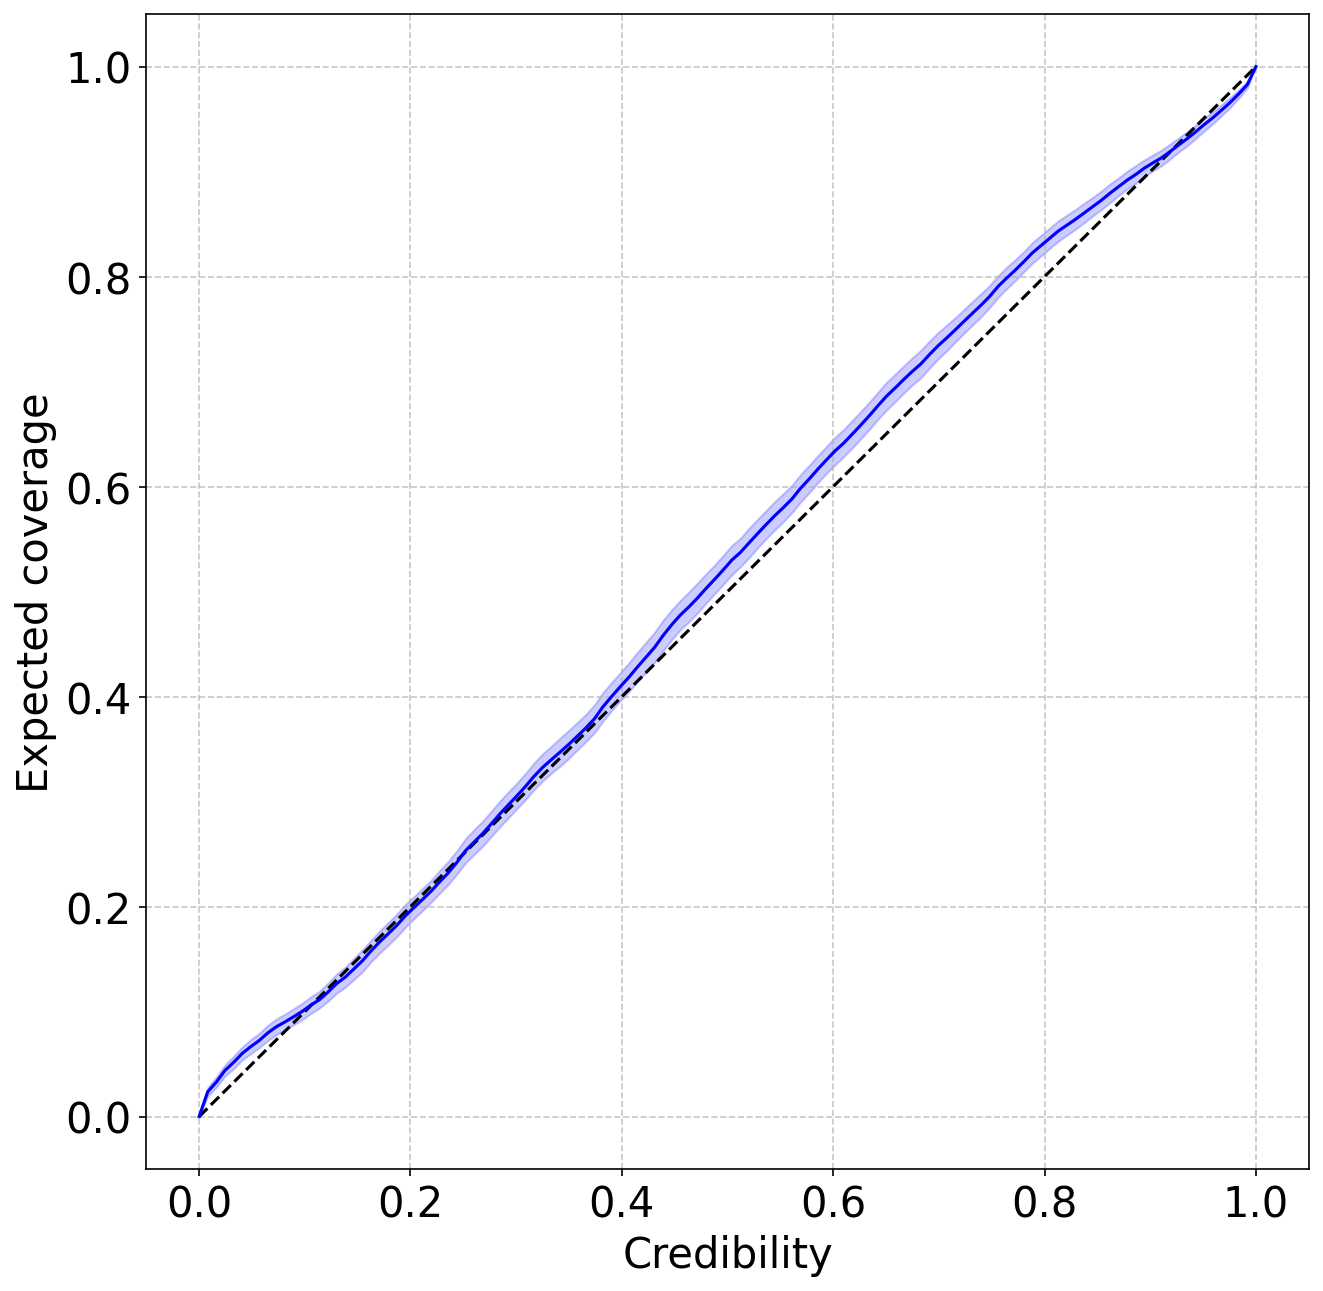

In [26]:

cov = diagnostics.PosteriorCoverageDirection(
    plot_list   = ["coverage", "histogram", "tarp"],
    num_samples = 1000,
    figsize     = (10, 10),   # 8 × 8 inches
    fontsize    = 20,       # axis labels & titles
    ticksize    = 20        # tick labels
)

figs = cov(
    posterior_tuned,
    x      = test_graphs,
    theta  = theta_true,
    signature = "posterior_tuned_"
)


# Evaluate the angular resolution of the pipeline on all the test events

INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74626.87it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 73430.69it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 73985.94it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 74691.99it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76450.35it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 75747.13it/s]                          
INFO:root:Sampling models with [2048] samples each.
Drawing 8192 posterior samples: 9000it [00:00, 76289.97it/s]                          
INFO:root:Sampling models w

Median R68 (HPD): 0.38026434 deg
Median R68 (cont): 0.522248 deg


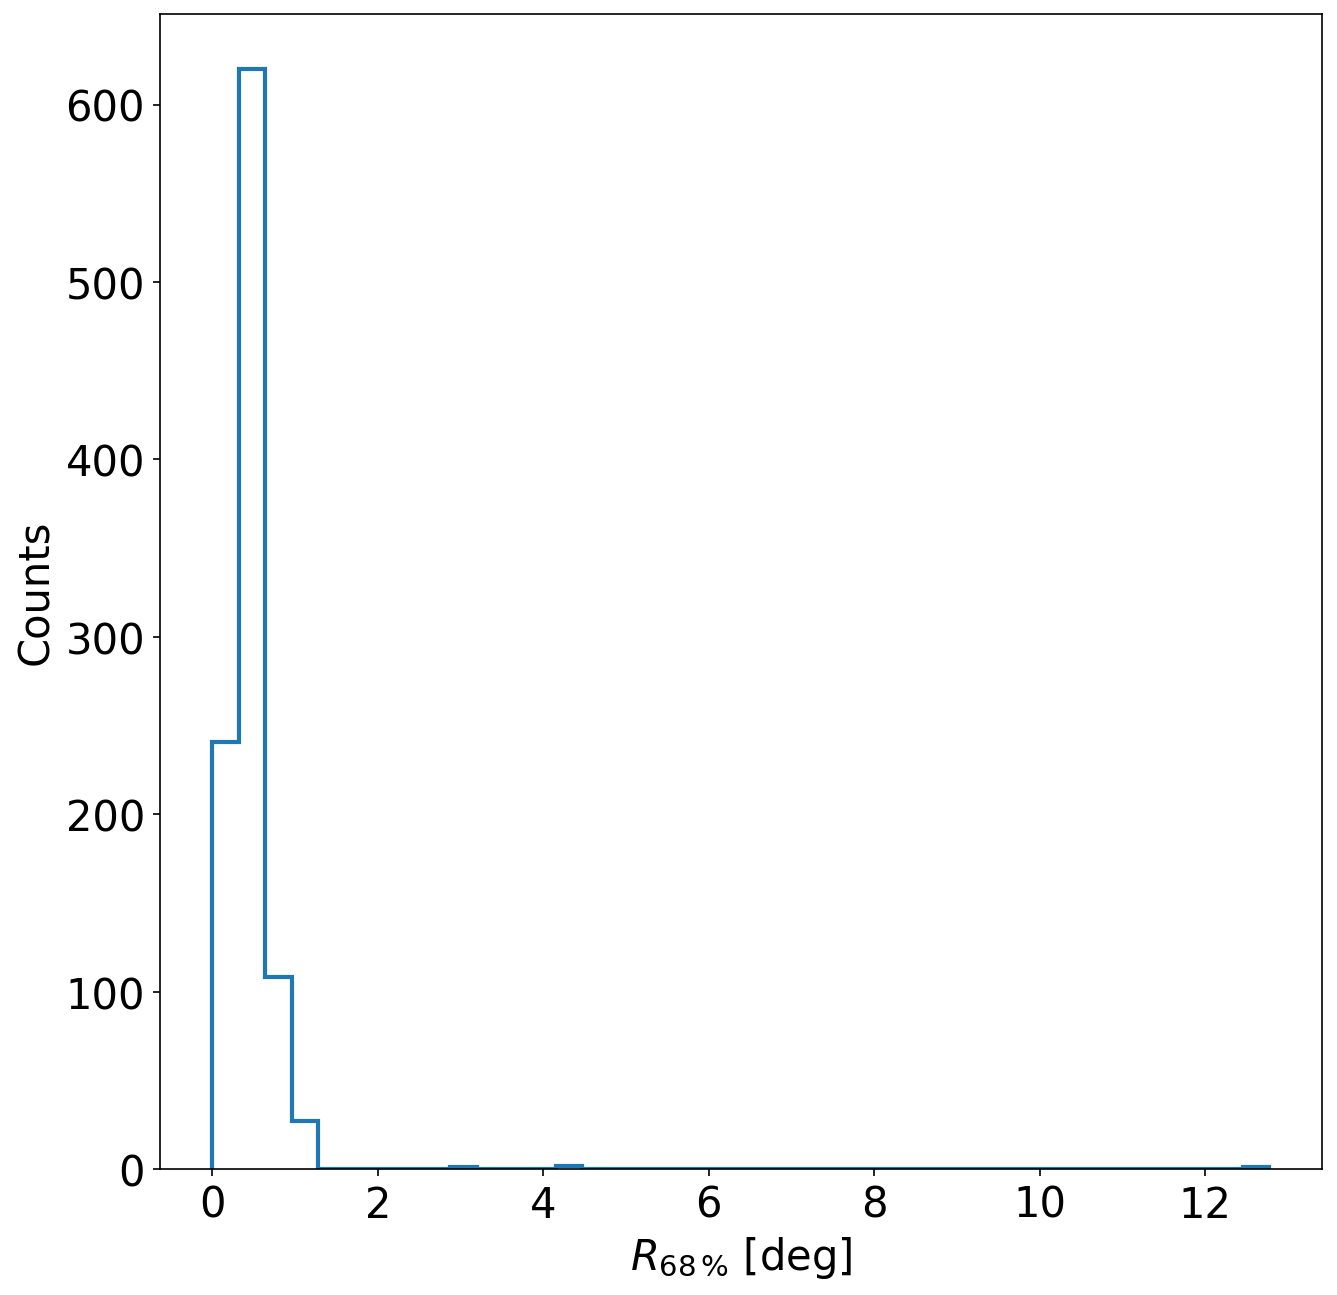

In [ ]:
# diagnostics_demo.ipynb  (Jupyter)

import torch
from torch_geometric.data import Batch
from sbi_uhecr_radio_recon.angular_resolution import run_diagnostics


#  Run the diagnostic on (say) 1 000 random test events
results = run_diagnostics(
    posterior      = posterior_tuned,
    test_loader    = test_loader,
    device         = device,
    subset_size    = 1000,     # None -> full test set
    out_dir        = "./",   # saves diagnostics_subset.npz here
)

# 3.  Quick sanity check
print("Median R68 (HPD):", np.nanmedian(results["R68_HPD_deg"]), "deg")
print("Median R68 (cont):", np.nanmedian(results["R68_CONT_deg"]), "deg")



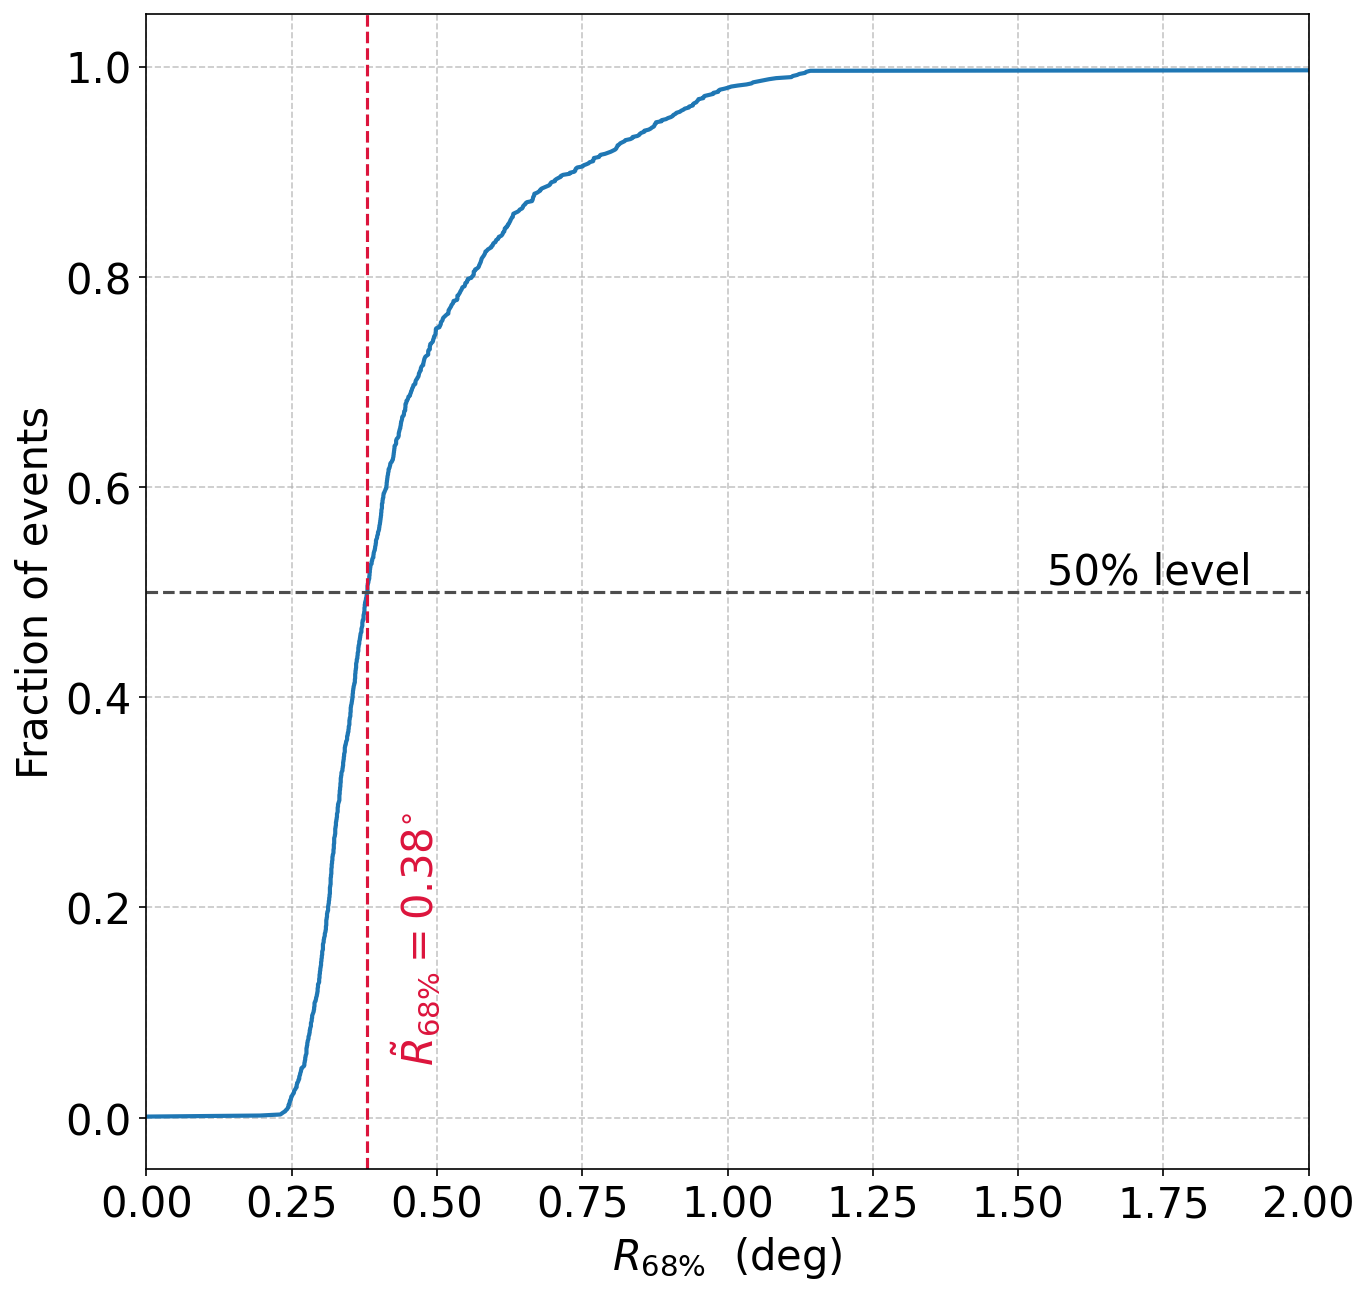

In [ ]:
# --- prerequisites ----------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# If you ran run_diagnostics() in the same session ...
R68_HPD_deg = results["R68_HPD_deg"]

# … or, if you restarted the kernel, simply reload the file you wrote earlier:
# R68_HPD_deg = np.load("./figures/diagnostics_subset.npz")["R68_HPD_deg"]

OUT_DIR = Path("./")           # change if needed
OUT_DIR.mkdir(exist_ok=True)

# --- global plot style (unchanged) ------------------------------------
plt.rcParams.update({
    "figure.figsize": (10, 10),
    "font.size": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "figure.dpi": 150,
    "grid.linestyle": "--",
    "grid.linewidth": 0.8,
    "grid.alpha": 0.7,
})

# --- CDF computation ---------------------------------------------------
x = np.sort(R68_HPD_deg)                  # ascending
y = np.arange(1, len(x) + 1) / len(x)     # empirical CDF

median = np.nanmedian(x)                  # robust to any NaNs you kept

# --- figure ------------------------------------------------------------
fig, ax = plt.subplots()
ax.plot(x, y, lw=2)

# 50-% reference lines
ax.axhline(0.5, ls="--", c="0.3")
ax.text(median * 5.0, 0.5, "50% level", ha="right", va="bottom")

ax.axvline(median, ls="--", c="crimson")
ax.text(median * 1.1, 0.05,
        fr"$\tilde{{R}}_{{68\%}} = {median:.2f}\!^\circ$",
        color="crimson", rotation=90, va="bottom")

ax.set_xlim(0, 2)
ax.set_xlabel(r"$R_{68\%}$  (deg)")
ax.set_ylabel("Fraction of events")

ax.grid(True)
fig.savefig(OUT_DIR / "F1_r68_cdf.pdf",
            bbox_inches="tight", transparent=True)
